<!--NOTEBOOK_HEADER-->
*This notebook contains material from [cbe30338-2021](https://jckantor.github.io/cbe30338-2021);
content is available [on Github](https://github.com/jckantor/cbe30338-2021.git).*


<!--NAVIGATION-->
< [3.4 Implementing Controllers in Python](https://jckantor.github.io/cbe30338-2021/03.04-Implementing-Controllers.html) | [Contents](toc.html) | [3.6 Lab Assignment 3: Relay and PI Control](https://jckantor.github.io/cbe30338-2021/03.06-Lab-Assignment-PI-Control.html) ><p><a href="https://colab.research.google.com/github/jckantor/cbe30338-2021/blob/master/docs/03.05-Proportional-Integral-Control-Copy1.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/cbe30338-2021/03.05-Proportional-Integral-Control-Copy1.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# 3.5 Practical Proportional (P) and Proportional-Integral (PI) Control

## 3.5.1 Learning Goals

* Explain terms in the equations for proportional control and proportional-integral control/
* Derive velocity from form of PI control.
* Define terminology
    * negative feedback
    * bias (aka offset or null) term
    * proportional gain and integral gain
* Explain difference between setpoint tracking and disturbance rejection.
* Explain roles of the proportional and integral terms contribute.
* Explain the purpose of each of the following enhancements of 'textbook' PI control:
    * Anti-reset windup
         * Control algorithm modifications
         * Event loop modifications
    * Bumpless Transfer

## 3.5.2 Negative Feedback

**Negative feedback** is the core principle underpinining process control.  Negative feedback suppresses deviations from the setpoint assuming the proportional gain is positive and the process exhibits a positive-going response from a positive change in the manipulated variable. If the process variable grows above the setpoint then the manipulated variable is decreased. If the process variable falls below the setpoint then the manipulated variable is increased.

If the system exhibits a negative-going response to a postive change in the manipiulated variable, then the sign of the proportional gain must also be negative to assure negative feedback control.

![](https://www.biologycorner.com/resources/feedback-loop-glucose.png)

**Positive feedback** is encountered in social, economic, and biological systems where there is a desire to amplify a desirable outcome. Positive feedback can induce good behaviors, result in 'virtuous' cycles of innovation and development, or wealth creation. But in most hard engineering situations, the immediate objective is to cause a variable to track a setpoint for which negative feedback is enabling technology

<hr>

**Study Question:** Describe the two types of negative feedback taking place in the glucose/insulin/glucagon system diagrammed above. 

**Study Question:** Why are two feedback loops necessary in this biological system? Can you think of an analogy for temperature control of a PCR thermal cycler?

**Study Question:** For the glucose feedback loops diagrammed above, describe at least one physiological source disturbance for each.

**Study Question:** Describe a situation where you have witnessed positive feedback in an audio or visual system.

<hr>

## 3.5.3 Proportional Control

### 3.5.3.1 Descripton

**Proportional control** adjusts the manipulated variable in proportion to the error between the setpoint and measured process variable.

\begin{align}
MV_k & = \bar{MV} - K_P(PV_k - SP_k)
\end{align}

The constant of proportionality, $K_p$, is called the **proportional control gain**. The **error signal** is the difference between the the measured process variable and setpoint,

\begin{align}
e_k & = PV_k - SP_k
\end{align}

for which the proportional control becomes

\begin{align}
MV_k & = \bar{MV} - K_P e_k
\end{align}

The negative sign results in **negative feedback control**. 

The constant term $\bar{MV}$ is called the **bias**, **offset**, or **null** value of the manipulated variable. It is an initial estimate of the value of the manipulated variable required to maintain the desired setpoint. The estimate can be determined in several ways:

* manual adjustment of the manipulated variable followed by a transition to automatic control,
* solving a process model for the desired steady state,
* feedforward control,
* a user provided estimate,
* set to zero.

In subsequent notebooks we will see how $\bar{MV}$ is used when building advanced control implementations.

### 3.5.3.2 Implementation

Using the Python `yield` statement, n instance of a proportional controller is created by specifying the gain $K_P$, upper and lower bounds on the manipulated variable, and the offset value $\bar{MV}$.

In [12]:
def P(Kp, MV_bar=0, MV_min=0, MV_max=100):
    MV = MV_bar
    while True:
        SP, PV = yield MV
        e = PV - SP
        MV = MV_bar - Kp*e

### 3.5.3.3 Controller Testing

Let's see how the proportional control works when applied to the Temperature Control Laboratory. For this simulation we set $\bar{MV} = 0$ and $K_p = 3.0$.

The following cell creates a function `experiment` that we can use to test controllers. The experiment tests the ability of the control to:

1. maintain a setpoint point for temperature T1, and
2. suppress the influence of a disturbance due to switching on the second heater.



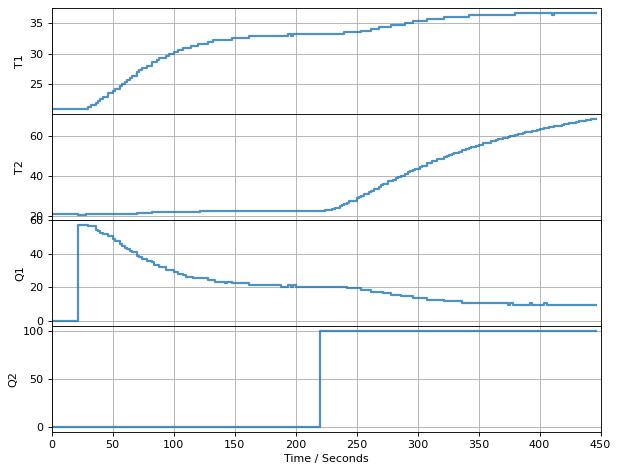

TCLab Model disconnected successfully.


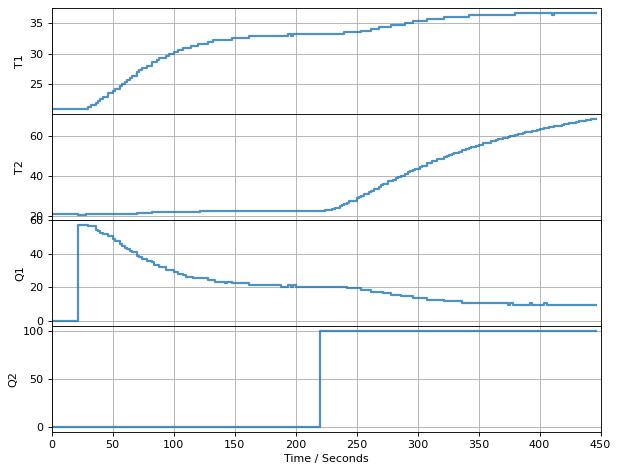

In [13]:
%matplotlib inline
from tclab import TCLab, clock, Historian, Plotter, setup

def setpoint(t):
    return 40 if t >= 20 else 0

def disturbance(t):
    return 100 if t>= 220 else 0

def experiment(controller, t_step=2, t_final=450,
               SP=lambda t: 40 if t >= 20 else 0, 
               D=lambda t: 100 if t >= 220 else 0):

    TCLab = setup(connected=False, speedup=60)
    with TCLab() as lab:
        h = Historian(lab.sources)
        p = Plotter(h, t_final)

        # initialize manipulated variable
        lab.P1 = 200
        lab.P2 = 200
        lab.Q1(next(controller))

        # event loop
        for t in clock(t_final, t_step):
            T1 = lab.T1
            U1 = controller.send((SP(t), T1))
            lab.Q1(U1)
            lab.Q2(D(t))
            p.update(t)    
            
controller = P(3.0)
experiment(controller, SP=setpoint, D=disturbance)

For systems without significant time delay and with properly chosen parameters, proportional control can achieve a fast response to changes in setpoint. Note, however, the steady state may be different than the desired setpoint, sometimes unacceptably different. This steady-state error a short-coming of purely proportional control.

<hr>

**Study Question:** Did the proportional control acheive the setpoint? Did proportional control reject the disturbance? How serious is the problem?

<hr>

### 3.5.3.4 Steady-State Offset

Proportional-only control provides no assurance the the process variable will eventually acquire the setpoint. To see this, consider the proportional control law

$$MV_k = \bar{MV} - K_P e_k$$

in the limit $k\rightarrow\infty$. 

$$e_{\infty} = \frac{\bar{MV} - M_{\infty}}{K_P}$$

The error $e_\infty$ expresses the steady-state difference between a process variable and it setpoint. With proportional control, the only options to reduce steady-state offset are 

1. Increase $K_P$. This leads to increasing oscillations and relay-like behavior of the manipulated variable.
2. Find a perfect initial estimate for $\bar{MV}$. If we could do this, we wouldn't need feedback control.

A persistent steady-state offset is most significant shortcoming of proportional-only control.

<hr>

**Study Question:** Test the simulation for values of $K_p$ that are twice as large, and half as large as demonstrated above. What do you notice about the steady-state error between the desired setpoint and the measured process variable?

<hr>

## 3.5.4 Proportional-Integral (PI) Control

### 3.5.4.1 Position form

Given a process variable $PV$ and setpoint $SP$, proportional-integral control is defined by the relation

\begin{align}
MV(t) & = \bar{MV} + K_P(SP(t) - PV(t)) + K_I\int_{-\infty}^t (SP(t') - PV(t'))\,dt'
\end{align}

where **$K_P$ is the proportional gain** and **$K_I$ is the integral gain**. When implemented in discrete time with time steps of length $h$, the basic rule for proportional-integral control becomes

\begin{align}
MV_k & = \bar{MV} + K_P(SP_k  - PV_k) + h K_I\sum_{j=0}^{j=k}(SP_j -  PV_j)
\end{align}

This is the so-called **position form** of PI control. This formula specifies the value (or "position") of the manipulated variable stricly in terms of the current and past values of the **error** signal

\begin{align}
e_k & = PV_k - SP_k
\end{align}

Note the sign convention: A positive error occurs when the process variable is greater than the setpoint. When written in terms of error,

The position form of PI control is rarely used in practice.

### 3.5.4.2 Velocity form

A more common implementation of PI control is done by computing how much the manipulated variable changes at each time step, and incrementing the manipulated variable by that amount.

Defining the error at time $k$ as

\begin{align}
e_k & = PV_k - SP_k
\end{align}

then consecutive values of $MV$ are given by 

\begin{align}
MV_{k-1} & = \bar{MV} - K_p e_{k-1} - h K_i \sum_{j=0}^{k-1} e_{j} \\
MV_{k} & = \bar{MV} - K_p e_{k} - h K_i \sum_{j=0}^{k} e_{j}
\end{align}

Taking differences gives a formula for updating the value of $MV$ in response to process measurements or changes in setpoint.

\begin{align}
MV_{k} & = MV_{k-1} - K_p(e_{k} - e_{k-1}) - h K_i e_{k}
\end{align}

with $MV_0 = \bar{MV}$. Let's see how this works.

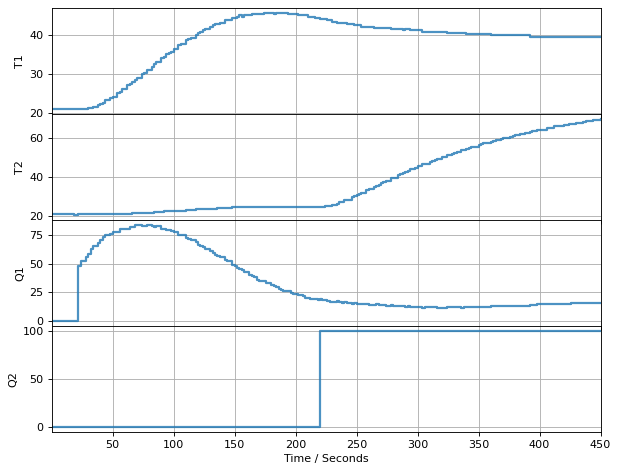

TCLab Model disconnected successfully.


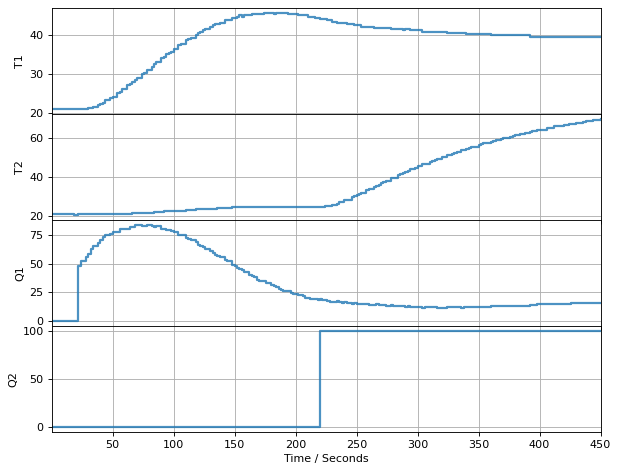

In [14]:
def PI(Kp, Ki, MV_bar=0, MV_min=0, MV_max=100):
    MV = MV_bar
    e_prev = 0
    while True:
        SP, PV = yield MV
        e = PV - SP
        MV += -Kp*(e - e_prev) - Ki*e
        e_prev = e
        
PI_controller = PI(3, 0.2)
experiment(PI_controller)

As we can see from this example, an important practical property of proportonal-integral control is **steady-state tracking of the setpoint.** In other words, for a steaady setpoint $\bar{SP}$, at steady-state 

\begin{align}
\lim_{k \rightarrow \infty} PV_k = \bar{SP}
\end{align}

To see why this is true, start with the velocity form of the proportional-integral controller

\begin{align}
MV_{k} & = MV_{k-1} - K_p(e_{k} - e_{k-1}) - h K_i e_{k}
\end{align}

At steady-state $MV_{k} = MV_{k-1}$ and $e_{k} = e_{k-1}$ leaving 

$$h K_i e_{k} = 0 \implies e_{k} = 0 \implies PV_{k} = \bar{SP}$$

Steady-state tracking is normally important in chemical process applications. For this reason, PI control is, by far, the most commonly encountered control used in the process industries.

## 3.5.5 Empirical Tuning Rules

There are a number of **tuning rules** in the literature that provide recommended values for the proportional gain $K_P$. These rules require process information obtained from testing. For a first-order plus time-delay (FOPTD), the available process information includes gain $K$, process time constant $T$, and process time delay $\tau$.

The most well-known tuning rules are due to Ziegler-Nichols (1948)

| Type | $K_P$ | $K_I$ |
| :---: | :---: | :---: |
| P | $\frac{T}{K\tau}$ | |
| PI | $\frac{0.9T}{K\tau}$ | $\frac{0.3T}{K\tau^2}$ |


Tuning rules are developed based on acheiving some performance criteria. Typical criteria include measures liks

\begin{align}
\text{IAE} & = \int_0^{\infty} |e(t)|dt \qquad \text{Integral Absolute Error}\\
\text{ISE} & = \int_0^{\infty} |e(t)|^2dt \qquad \text{Integral Square Error}\\
\text{ITAE} & = \int_0^{\infty} t|e(t)|dt \qquad \text{Integral Time Absolute Error}\\
\end{align}


one example of recommended values are (see Astrom and Murray, Chapter 11):

| Type | $K_P$ | $K_I$ |
| :---: | :---: | :---: |
| PI | $\frac{0.15\tau + 0.35T}{K\tau}$ | $\frac{0.46\tau + 0.02T}{K\tau^2}$ |


<hr>

**Study Question:** Repeat the simulation experiments using the Ziegler-Nichols and the Astrom and Murray tuning rules for PI control. Compare the magnitude of the recommended control constants. Compare the resulting performance in response to regard to both setpoint tracking and disturbance rejection. Compare:

* Maximum overshoot
* Damping
* Time to acheive steady-state

<hr>

## 3.5.6 Anti-Reset Windup

### 3.5.6.1 What is Integral (aka Reset) Windup?

In the next cell we're doing an experiment in which we increase the magnitude of the control gains to see if we an acheive even better control performance. Let's see how we do.

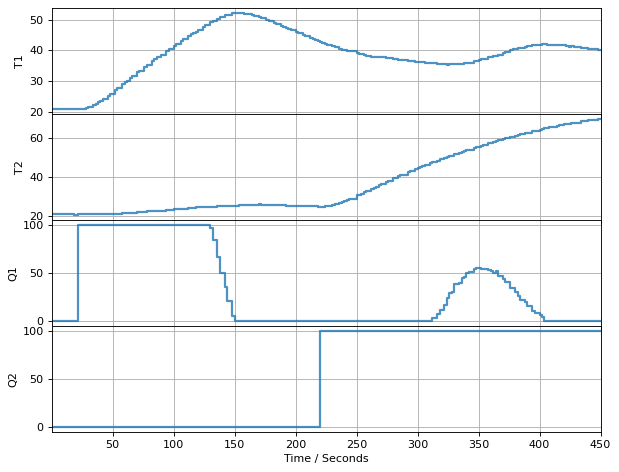

TCLab Model disconnected successfully.


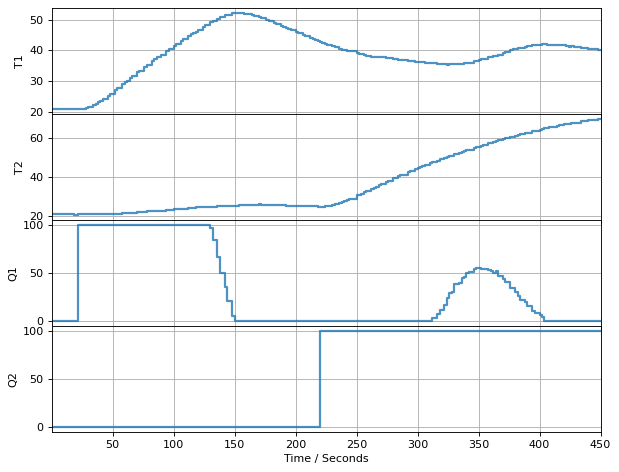

In [15]:
PI_controller = PI(10, 1.0)
experiment(PI_controller)

<hr>

**Study Question:** Carefully exammine the results of this experiment. The PI velocity algorithm is given by an equation

\begin{align}
MV_{k} & = MV_{k-1} - K_p(e_{k} - e_{k-1}) - h K_i e_{k}
\end{align}

Looking at the period from 0 to 100 seconds, is this equation being satisfied? Why or why not?  

**Study Question:** Carefully examine the code for the PI controller. How is it possible for $MV$ to be different from the actual input applied to the device?

<hr>

**Integral (aka Reset) windup is a consequence the manipulable input to a process being different from what the control equation specifies for the input. The difference is due to the presence of upper and lower bounds on the manipulated variable.**

### 3.5.6.2 Anti-reset windup - Part 1

There several common strategies for avoiding integral (aka reset) windup. The first of these, which should be part of any practical implementation, is to limit computed values of manipulated variable to the range of allowable values. This will avoid $MV$ 'winding up' due to range limits.

\begin{align}
\hat{MV}_{k} & = MV_{k-1} - K_p(e_{k} - e_{k-1}) - h K_i e_{k} 
\end{align}

\begin{align}
MV_k & = \max(MV^{min}, \min(MV^{max}, \hat{MV}_k)
\end{align}

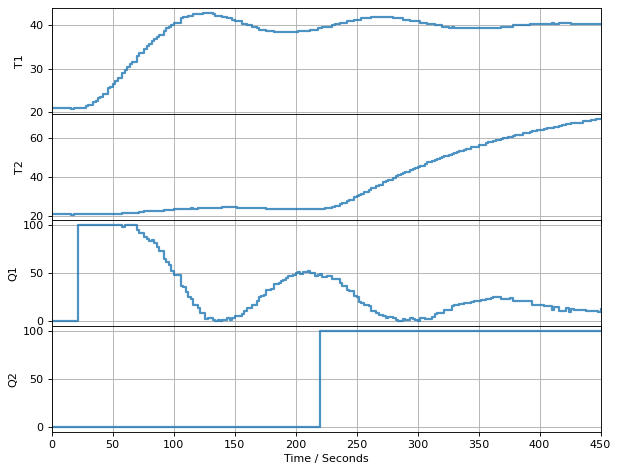

TCLab Model disconnected successfully.


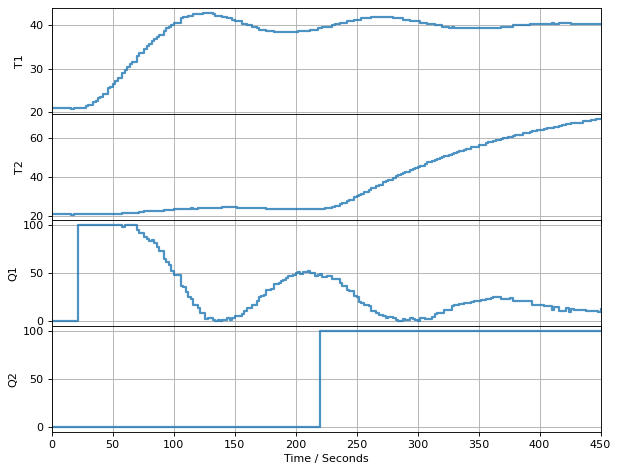

In [16]:
def PI_antiwindup(Kp, Ki, MV_bar=0, MV_min=0, MV_max=100):
    MV = MV_bar
    e_prev = 0
    while True:
        SP, PV = yield MV
        e = PV - SP
        MV += - Kp*(e - e_prev) - Ki*e
        MV = max(MV_min, min(MV_max, MV))   # <=== enforce constraints on MV to avoid integral windup
        e_prev = e
        
controller = PI_antiwindup(10, 1.0)
experiment(controller)

### 3.5.6.3 Anti-reset Windup - Part 2

A more subtle form of windup occurs when the manipulated variable is subject to external interventions. This can occur when a valve stem in a process application gets stuck, an operator or user intervenes and resets a mechanical actuator, or there is some sort of system failure. 

For these reasons, practical control systems often include a field measurement of the manipulated variable that is fed back to the controller. The following image, for example, shows a pneumatically operated globe valve with a positioner, and with feedback of position to the central control system.

<p><a href="https://commons.wikimedia.org/wiki/File:Pl_control_valve.jpg#/media/File:Pl_control_valve.jpg"><img src="https://upload.wikimedia.org/wikipedia/commons/b/b2/Pl_control_valve.jpg" alt="Pl control valve.jpg" height="720" width="540"></a>
    
 <a href="https://creativecommons.org/licenses/by-sa/3.0" title="Creative Commons Attribution-Share Alike 3.0">CC BY-SA 3.0</a>
    
Stepper motors are commonly used actuators in lab equipment and robotics. The position of the stepper motor would be manipulated variable. This is an example of a stepper motor with an integrated encoder that can be used to verify the motor's position.
    
![](https://www.portescap.com/-/media/project/automation-specialty/portescap/portescap/products/workings-of-encoders/encoder_chart_720x450_1_0.jpg)

This behavior also occurs in the Temperature Control Laboratory in which the manipulated power levels are constrained to the range 0% to 100%. This is demonstated in the following cell.

In [16]:
# show that inputs to the TCLab are constrained to the range 0 to 100%

TCLab = setup(connected=False, speedup=20)
with TCLab() as lab:
    print(f"Q1 = {lab.Q1()}")
    lab.Q1(150)
    print(f"Q1 = {lab.Q1()}")

TCLab version 0.4.9
Simulated TCLab
Q1 = 0
Q1 = 100
TCLab Model disconnected successfully.


To accomodate feedback of the manipulated variable, we first need to modify the event loop to incorporate the measurement of the manipulated variable, then send that value to the controller.

In [17]:
%matplotlib inline
from tclab import TCLab, clock, Historian, Plotter, setup

def experiment(controller, t_final=450, t_step=2,
               SP=lambda t: 40 if t >= 20 else 0, 
               D=lambda t: 100 if t >= 220 else 0):
    TCLab = setup(connected=False, speedup=60)
    with TCLab() as lab:

        # set up historian and plotter
        h = Historian(lab.sources)
        p = Plotter(h, t_final)

        # initialize manipulated variable
        lab.P1 = 200
        lab.Q1(next(controller))

        # event loop
        for t in clock(t_final, t_step):
            T1 = lab.T1
            U1 = lab.Q1()                            # <==== new line
            U1 = controller.send((SP(t), T1, U1))    # <==== send U1 to controller 
            lab.Q1(U1)
            lab.Q2(D(t))
            p.update(t)     

The next change is to the controller. The controller now accepts values for PV, SP, and, additionally, MV. To demonstrate the impact of these changes, this example will comment out the software limits placed on MV to show that feedback of manipulated variable is also an anti-reset windwup strategy.

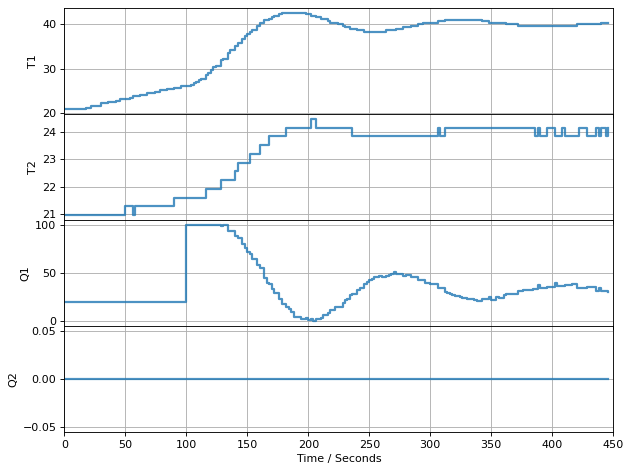

TCLab Model disconnected successfully.


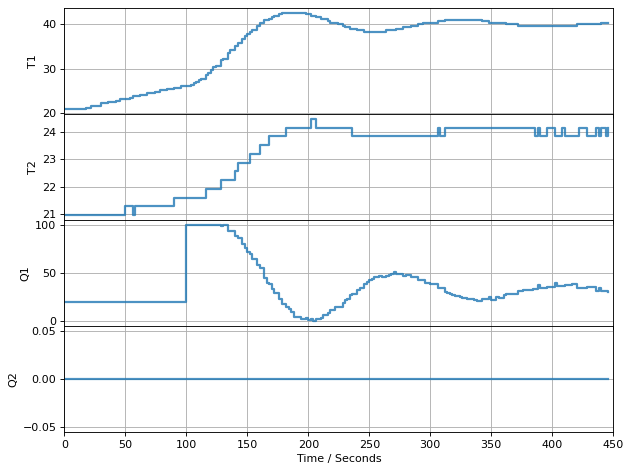

In [22]:
def PI_antiwindup(Kp, Ki, MV_bar=0, MV_min=0, MV_max=100):
    MV = MV_bar
    e_prev = 0
    while True:
        SP, PV, MV = yield MV   # <==== now gets MV from experiment
        e = PV - SP
        MV += -Kp*(e - e_prev) - Ki*e
        MV = max(MV_min, min(MV_max, MV))
        e_prev = e
        
controller = PI_antiwindup(10, 1.0)
experiment(controller)

## 3.5.7 Bumpless Transfer

1. Set $\bar{MV}$ equal to the current value of the manipulated variable.
2. Set the setpoint equal to the current value of the process variable.



### 3.5.7.1 Manual Operation

Manual operation allows the user to specify the manipulated variable. 

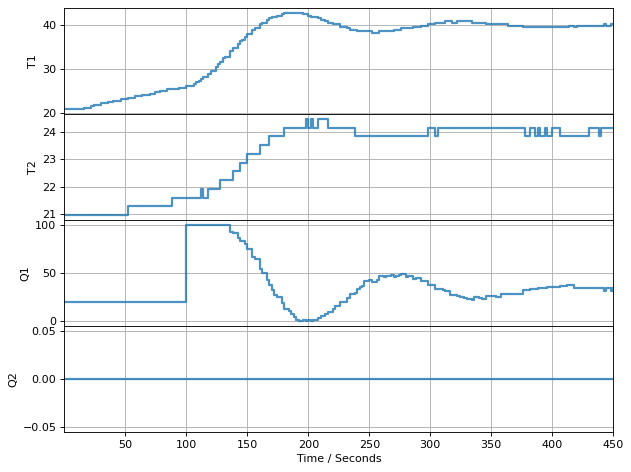

TCLab Model disconnected successfully.


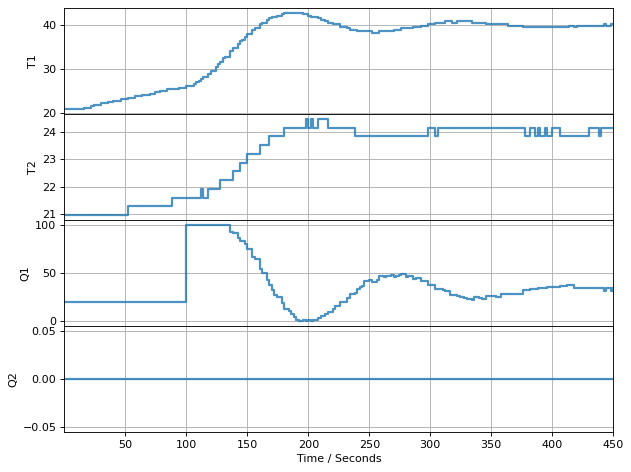

In [23]:
%matplotlib inline
from tclab import TCLab, clock, Historian, Plotter, setup

def experiment(controller, t_final=450, t_step=2,
               SP=lambda t: 40 if t >= 20 else 0):
    TCLab = setup(connected=False, speedup=60)
    with TCLab() as lab:

        # set up historian and plotter
        h = Historian(lab.sources)
        p = Plotter(h, t_final)

        # initialize manipulated variable
        lab.P1 = 200
        next(controller)
        lab.Q1(20)

        # event loop 
        for t in clock(t_final, t_step):
            T1 = lab.T1
            U1 = lab.Q1()
            if t < 100:
                # manual control
                U1 = controller.send((T1, T1, U1))
            else:
                U1 = controller.send((SP(t), T1, U1))
            lab.Q1(U1)
            p.update(t)   
            
controller = PI_antiwindup(10, 1.0)
experiment(controller)

### 3.5.7.2 Setpoint on Integral

\begin{align}
\hat{MV}_{k} & = MV_{k-1} - K_p(PV_{k} - PV_{k-1}) - h K_i e_{k} 
\end{align}

\begin{align}
MV_k & = \max(MV^{min}, \min(MV^{max}, \hat{MV}_k)
\end{align}

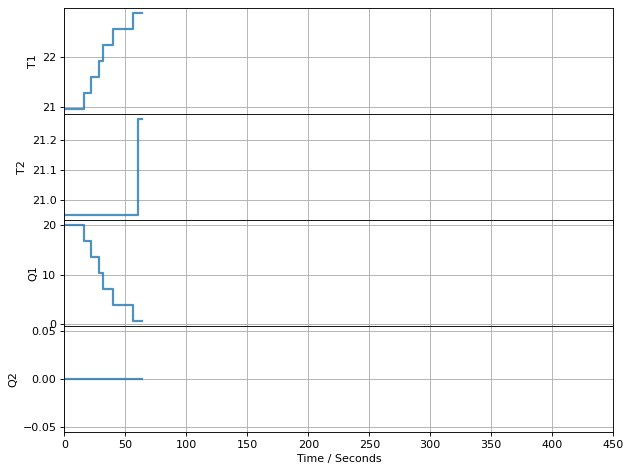

TCLab Model disconnected successfully.


KeyboardInterrupt: 

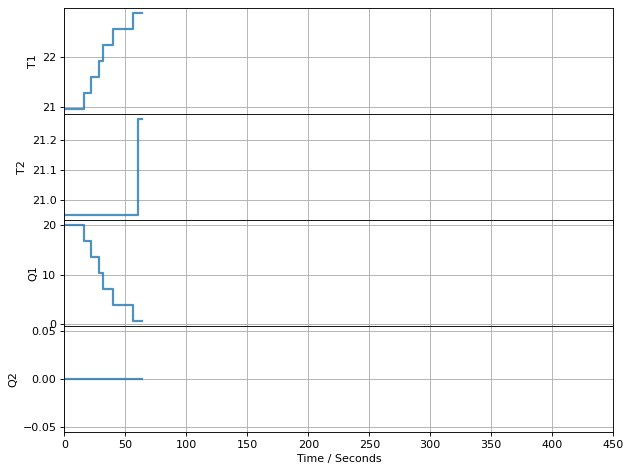

In [26]:
def PI_antiwindup(Kp, Ki, MV_bar=0, MV_min=0, MV_max=100):
    SP, PV, MV = yield MV_bar
    MV += -Ki*(PV - SP)
    MV = max(MV_min, min(MV_max, MV))
    PV_prev = PV
    while True:
        SP, PV, MV = yield MV 
        MV += -Kp*(PV - PV_prev) - Ki*(PV - SP)
        MV = max(MV_min, min(MV_max, MV))
        PV_prev = PV
        
controller = PI_antiwindup(10, 1.0)
experiment(controller)

<!--NAVIGATION-->
< [3.4 Implementing Controllers in Python](https://jckantor.github.io/cbe30338-2021/03.04-Implementing-Controllers.html) | [Contents](toc.html) | [3.6 Lab Assignment 3: Relay and PI Control](https://jckantor.github.io/cbe30338-2021/03.06-Lab-Assignment-PI-Control.html) ><p><a href="https://colab.research.google.com/github/jckantor/cbe30338-2021/blob/master/docs/03.05-Proportional-Integral-Control-Copy1.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/cbe30338-2021/03.05-Proportional-Integral-Control-Copy1.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>